## Курс "Нейронные сети и глубокое обучение"
#### Группа 6231-010402D
#### Магистр Чаплыгин А.О.
### Лабораторная работа 1

1) Классификация данных методом k ближайших соседей ( kNN)

2) Классификация данных методом опорных векторов (SVM)

3) Построение softmax-классификатора

Вариант 1: задания 1 и 2 на наборе данных CIFAR-10

In [1]:
import time
import random
import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow.keras.datasets import cifar10
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager

from sklearn.metrics import accuracy_score
from datetime import datetime
from scipy import spatial

In [2]:
from scripts.classifiers import KNearestNeighbor
from scripts.classifiers.linear_svm import svm_loss_naive
from scripts.classifiers.linear_svm import svm_loss_vectorized
from scripts.classifiers.linear_classifier import LinearSVM
from scripts.gradient_check import grad_check_sparse

In [3]:
# MAIN

# Метод отображения заданного количества изображений из общего массива
def draw_first_images(dict_classes, img, labels, idx, num):
    fig = plt.gcf()
    fig.set_size_inches(12, 14)
    for i in range(0, num):
        ax = plt.subplot(5, 10, 1 + i)
        ax.imshow(img[idx], cmap = 'binary')
        title = dict_classes[labels[i][0]]
        ax.set_title(title, fontsize = 10)
        ax.set_xticks([]); ax.set_yticks([])
        idx += 1
    plt.show()
    
# Метод отображения заданного количества изобрежйний с разбиением по классам
def draw_images (img, classes, raw_num):
    fig, axes = plt.subplots(nrows = raw_num, ncols = 10)
    fig.set_size_inches(12, round(1*raw_num))
    n = 1
    for ax in axes.flat:
        if n < 11:
            ax.set(title = classes[n-1], xticks=[], yticks=[])
            ax.imshow(img[n-1][0], cmap = 'binary')
        elif n < 101:
            ax.set(title = '', xticks=[], yticks=[])
            raw_num = str(n-1)
            cl = int(raw_num[1], base = 10)
            k = int(raw_num[0], base = 10) 
            ax.imshow(img[cl][k], cmap = 'binary')
        else:
            ax.set(title = '', xticks=[], yticks=[])
            raw_num = str(n-1)
            cl = int(raw_num[2], base = 10)
            k = int(raw_num[1], base = 10) 
            ax.imshow(img[cl][k], cmap = 'binary')
        n += 1
    plt.show()

### 1. Классификация данных методом k ближайших соседей ( kNN)
#### 1.1 Скачайте данные в соответсвии с заданием. CIFAR-10 по ссылке https://www.cs.toronto.edu/~kriz/cifar.html
Дата сет CIFAR-10 содержит 60000 изображений размера 32x32 разбитых на 10 классов:
<ol>
    <li>самолет</li>
    <li>автомобиль</li>
    <li>птица</li>
    <li>кошка</li>
    <li>олень</li>
    <li>собака</li>
    <li>лягушка</li>
    <li>лошадь</li>
    <li>корабль</li>
    <li>грузовик</li>
 </ol>

In [4]:
cifar = cifar10.load_data()
cifar = tf.keras.datasets.cifar10.load_data()

In [5]:
# x - изображение, y - метки классов
(x_train, y_train), (x_test, y_test) = cifar
print ('Training data shape: ', x_train.shape)
print ('Training labels shape: ', y_train.shape)
print ('Test data shape: ', x_test.shape)
print ('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000, 1)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000, 1)


#### 1.2 Выведите несколько примеров изображений из обучающей выборки для каждого класса.

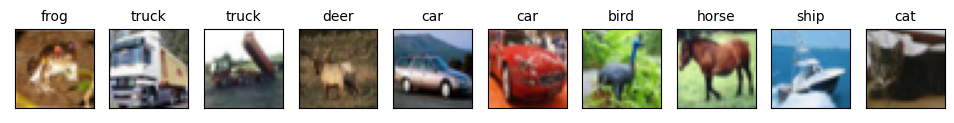

In [6]:
# Словарь классов выборки
dict_classes = {0:'plane', 1:'car', 2:'bird', 3:'cat', 4:'deer', 5:'dog', 6:'frog', 7:'horse', 8:'ship', 9:'truck'}
# Количество примеров изображений
N = 10
# Отображаем
draw_first_images (dict_classes, x_train, y_train, 0, N) 

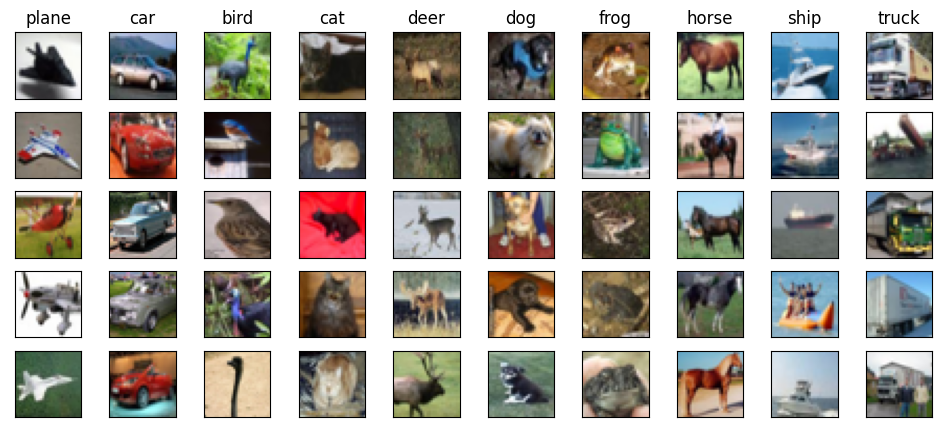

In [7]:
# Формируем массив изоражений с разбиений по классам
dict_img = {}
for i in range(N):
    l = []
    for j in range(x_train.shape[0]):
        if y_train[j][0] == i: 
            l.append(x_train[j])         
    dict_img[i] = l
# Отображаем
draw_images (dict_img, dict_classes, 5)

#### 1.3 Разделите данные на обучающу и тестовую выборки (X_train, y_train, X_test, y_test). Преобразуйте каждое изображение в одномерный массив.

In [8]:
# Определяем объем выборки для обучения
num_training = x_train.shape[0]
#num_training = 10000
mask = list(range(num_training))
x_train_mask = x_train[mask]
y_train_new = y_train[mask]

# Определяем объем выборки для теста
num_test = x_test.shape[0]
#num_test = 1000
mask = list(range(num_test))
x_test_mask = x_test[mask]
y_test_new = y_test[mask]

# Формируем одномерный массив
x_train_new = np.reshape(x_train_mask, (x_train_mask.shape[0], -1))
x_test_new = np.reshape(x_test_mask, (x_test_mask.shape[0], -1))
print(x_train_new.shape, x_test_new.shape, y_train_new.shape, y_test_new.shape)

(50000, 3072) (10000, 3072) (50000, 1) (10000, 1)


#### 1.4 Напишите реализацию классификатора в скрипте /classifiers/k_nearest_neighbor.py и обучите его на сформированной выборке.

In [9]:
model_KNN = KNearestNeighbor()
model_KNN.train(x_train_new, y_train_new)

#### 1.5 Выполните классификацию на тестовой выборке

In [10]:
start_time_two_loops = datetime.now()
dists_two_loops = model_KNN.compute_distances_two_loops(x_test_new)
time_two_loops = datetime.now() - start_time_two_loops
print(dists_two_loops.shape)
print( 'Time two loops: ', time_two_loops)

(10000, 50000)
Time two loops:  1:14:11.971742


In [ ]:
start_time_one_loop = datetime.now()
dists_one_loop = model_KNN.compute_distances_one_loop(x_test_new)
time_one_loop = datetime.now() - start_time_one_loop
print(dists_one_loop.shape)
print( 'Time one loop: ', time_one_loop)

In [ ]:
start_time_no_loops = datetime.now()
dists_no_loops = model_KNN.compute_distances_no_loops(x_test_new)
time_no_loops = datetime.now() - start_time_no_loops
print(dists_no_loops.shape)
print( 'Time no loops: ', time_no_loops)

#### 1.6 Визуализируйте матрицу расстояний для каждого изображения из тестовой выборки до изображений из обучающей выборки.

In [ ]:
plt.imshow(dists_two_loops, interpolation = 'none')
plt.show()

In [ ]:
plt.imshow(dists_one_loop, interpolation = 'none')
plt.show()

In [ ]:
plt.imshow(dists_no_loops, interpolation = 'none')
plt.show()

#### 1.7 Посчитайте долю правильно классифицированных изображений из тестовой выборки.

In [ ]:
# Формируем данные для обработки
y_test_new_array = []
for i in range (y_test_new.shape[0]):
    y_test_new_array.append(np.float64(y_test_new[i][0]))
    
y_test_new_array = np.array(y_test_new_array)

In [ ]:
# Two loops
y_test_pred_two_loops = model_KNN.predict_labels(dists_two_loops, k = 2)
print ('Доля правильно классифицированных на "Two loops":', np.sum(y_test_pred_two_loops == y_test_new_array) / num_test)
# One loop
y_test_pred_one_loop = model_KNN.predict_labels(dists_one_loop, k = 2)
print ('Доля правильно классифицированных на "One loop":', np.sum(y_test_pred_one_loop == y_test_new_array) / num_test)
# No loops
y_test_pred_no_loops = model_KNN.predict_labels(dists_no_loops, k = 2)
print ('Доля правильно классифицированных на "No loops":', np.sum(y_test_pred_no_loops == y_test_new_array) / num_test)

#### 1.8 Постройте график зависимости доли правильно классифицированных изображений от числа соседей, используемых при классификации.

In [ ]:
neighbors = [1, 2, 3, 4, 5, 8, 10, 12, 15, 20, 25, 30, 35, 40, 45, 50]
accur = {1:0, 2:0, 3:0, 4:0, 5:0, 8:0, 10:0, 12:0, 15:0, 20:0, 25:0, 30:0, 35:0, 40:0, 45:0, 50:0}
knn_accuracy = []

for k in neighbors:
    knn_model = KNearestNeighbor()
    knn_model.train(x_train_new, y_train_new)
    dists = knn_model.compute_distances_no_loops(x_test_new)
    y_test_pred_knn = knn_model.predict_labels(dists, k = k)
    knn_accuracy.append(np.sum(y_test_pred_knn == y_test_new_array) / num_test)
    accur[k] = np.sum(y_test_pred_knn == y_test_new_array) / num_test

In [ ]:
print('Accuracy: ', accur)

In [ ]:
print('KNN Accuracy: ', knn_accuracy)

In [ ]:
# график зависимости
plt.plot(neighbors, knn_accuracy, label = 'график зависимости от числа соседей')
plt.legend()
plt.xlabel('число соседей')
plt.ylabel('доля правильно классифицированных')
plt.show()

#### 1.9 Выберите лучшее значение параметра k на основе кросс-валидации.

In [ ]:
best_neighbors = max(accur, key = accur.get)
print(best_neighbors)

#### 1.10 Переобучите и протестируйте классификатор с использованием выбранного значения k.

In [ ]:
model_KNN_best = KNearestNeighbor()
model_KNN_best.train(x_train_new, y_train_new)

y_test_pred_no_loops = model_KNN_best.predict_labels(dists_no_loops, k = best_neighbors)
print ('Доля правильно классифицированных на "Two loops":', np.sum(y_test_pred_no_loops == y_test_new_array) / num_test)
y_test_pred_one_loop = model_KNN_best.predict_labels(dists_one_loop, k = best_neighbors)
print ('Доля правильно классифицированных на "One loop":', np.sum(y_test_pred_one_loop == y_test_new_array) / num_test)
y_test_pred_no_loops = model_KNN.predict_labels(dists_no_loops, k = best_neighbors)
print ('Доля правильно классифицированных на "No loops":', np.sum(y_test_pred_no_loops == y_test_new_array) / num_test)

#### 1.11 Сделайте выводы по результатам 1 части задания.

In [ ]:
print('two_loops time:', time_two_loops)
print('one_loop time:', time_one_loop)
print('no_loops time:', time_no_loops)

#### Вывод
При вычислении расстояния между всеми тестовыми выборками и всеми обучающими выборками использовали разные алгоримы:
<ul>
    <li>two_loops - использует двойной цикл (наименее эффективна в плане времени)</li>
    <li>one_loops - использует один цикл</li>
    <li>no_loops - не использует цикл</li>
</ul>
</br>
В плане доли правильно классифицированных нет большой разницы:</br>
На полной выборке</br>
<ul>
    <li></li>
    <li></li>
</ul>
На средней выборке</br>
<ul>
    <li>no_loops и two_loops дает одинаковую точность</li>
    <li>one_loops точность выше</li>
</ul>
На маленькой выборке</br>
<ul>
    <li>no_loops и two_loops дает одинаковую точность</li>
    <li>one_loops точность ниже</li>
</ul>
</br>
Матрица матрица расстояний в случае "no_loops" более информативна:
<ul>
    <li>Cтрока ярче - тестовые данные отличаются от данных обучения</li>
    <li>Cтолбец ярче - данные обучения отличаются от тестовых данных</li>
</ul>
</br>
Наименьшее время работы дает "no_loops"</br>
Худшее время - two_loops</br>
Лучший результат: one_loop, k = 2

### 2. Классификация данных методом опорных векторов (SVM)

In [ ]:
(X_train, y_train), (X_test, y_test) = cifar

#### 2.1 Разделите данные на обучающую, тестовую и валидационную выборки. Преобразуйте каждое изображение в одномерный массив. Выведите размеры выборок.

In [ ]:
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

mask = np.random.choice(num_training, num_dev, replace = False)
X_dev = X_train[mask]
y_dev = y_train[mask]

mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

print (X_train.shape)
print (y_train.shape)

print (X_val.shape)
print (y_val.shape)

print (X_test.shape)
print (y_test.shape)

print (X_dev.shape)
print (y_dev.shape)

In [ ]:
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) 
plt.figure(figsize = (4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) 
plt.show()

#### 2.2 Проведите предварительную обработку данных, путем вычитания среднего изображения, рассчитанного по обучающей выборке.

In [ ]:
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) 
plt.figure(figsize = (4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) 
plt.show()

In [ ]:
X_train = X_train - mean_image
X_val = X_val -mean_image
X_test = X_test - mean_image
X_dev = X_dev - mean_image

#### 2.3 Чтобы далее не учитывать смещение (свободный член b), добавьте дополнитульную размерность к массиву дынных и заполните ее 1.

In [ ]:
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

#### 2.4 Реализуйте loss-функции в scripts/classifiers/linear_svm.py

In [ ]:
W = np.random.randn(X_dev.shape[1], 10) * 0.0001

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.00001)
print('loss: %f' % (loss, ))

#### 2.5 Убедитесь, что вы верно реализовали расчет градиента, сравнив с реализацией численными методами (код приведен ниже).

In [ ]:
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

In [ ]:
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

#### 2.6 Сравните svm_loss_naive и svm_loss_vectorized реализации

In [ ]:
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

In [ ]:
tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

#### 2.7 Реализуйте стохастический градиентный спуск в /classifiers/linear_classifier.py . Реализуйте методы train() и predict() и запустите следующий код

In [ ]:
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4, num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

In [ ]:
y_train_pred_svm = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred_svm), ))

In [ ]:
y_val_pred_svm = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred_svm), ))

#### 2.8 С помощью кросс-валидации выберите значения параметров скорости обучения и регуляризации. В кросс-валидации используйте обучающую и валидационную выборки. Оцените accuracy на тестовой выборке.

In [ ]:
learning_rates = [1e-7, 5e-5]
regularization_strengths = [2.5e4, 5e4]
results = {}
best_val = -1   
best_svm = None

In [ ]:
for lr in learning_rates:
    for reg in regularization_strengths:
        svm = LinearSVM()
        svm.train(X_train, y_train, lr, reg, num_iters=2000, verbose=False)
        y_train_pred = svm.predict(X_train)
        y_val_pred = svm.predict(X_val)
        training_accuracies = np.mean(y_train == y_train_pred)
        validation_accuracies = np.mean(y_val == y_val_pred)
        results[(lr, reg)] = (training_accuracies, validation_accuracies)
        if validation_accuracies > best_val:
            best_val = validation_accuracies

In [ ]:
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (lr, reg, train_accuracy, val_accuracy))

In [ ]:
print('best validation accuracy achieved during cross-validation: %f' % best_val)

#### 2.9 Сделайте выводы по второй части задания
Время работы при реализации svm_loss_naive выше, чем при реализации svm_loss_vectorized</br>
Наилучшая точность, достигнутая во время перекрестной проверки = 0.102575